In [43]:
# !pip install pystac[validation]

In [44]:
# ! pip install pystac
# ! pip install rasterio
# ! pip install shapely

In [45]:
import os
import rasterio
import urllib.request
import pystac

from shapely.geometry import Polygon, mapping
from datetime import datetime, timezone
from tempfile import TemporaryDirectory

from pystac.extensions.eo import Band, EOExtension
from pystac.extensions.view import ViewExtension
from pystac.extensions.projection import ProjectionExtension

In [46]:
# Set the temporary directory to store source data
# tmp_dir = TemporaryDirectory()
img_path = os.path.join('data','gobindpur_lulc_2024.tif')

# # Fetch and store data
# url = ('https://spacenet-dataset.s3.amazonaws.com/'
#        'spacenet/SN5_roads/train/AOI_7_Moscow/MS/'
#        'SN5_roads_train_AOI_7_Moscow_MS_chip996.tif')
# urllib.request.urlretrieve(url, img_path)

In [47]:
img_path

'data/gobindpur_lulc_2024.tif'

In [48]:
# !cp data/gobindpur_lulc_2024.tif tmp_dir

In [49]:
def get_bbox_and_footprint(raster):
    with rasterio.open(raster) as r:
        crs = r.crs
        res = r.res
        transform = r.transform
        linear_units = crs.linear_units

        bounds = r.bounds
        bbox = [bounds.left, bounds.bottom, bounds.right, bounds.top]
        footprint = Polygon([
            [bounds.left, bounds.bottom],
            [bounds.left, bounds.top],
            [bounds.right, bounds.top],
            [bounds.right, bounds.bottom]
        ])       
        tags = r.tags()
        date_str = tags.get("TIFFTAG_DATETIME")
        print(date_str)
        return (bbox, mapping(footprint),crs,res,transform,linear_units)

In [50]:
bbox, footprint,crs,res,transform,linear_units = get_bbox_and_footprint(img_path)

None


In [51]:
res

(0.008983152841195215, 0.008983152841195215)

In [52]:
transform

Affine(0.008983152841195215, 0.0, 85.48907232851838,
       0.0, -0.008983152841195215, 23.205639745489126)

In [53]:
linear_units

'unknown'

In [54]:
bbox

[85.48907232851838, 22.42410544830514, 86.30653923706714, 23.205639745489126]

In [55]:
footprint

{'type': 'Polygon',
 'coordinates': (((85.48907232851838, 22.42410544830514),
   (85.48907232851838, 23.205639745489126),
   (86.30653923706714, 23.205639745489126),
   (86.30653923706714, 22.42410544830514),
   (85.48907232851838, 22.42410544830514)),)}

In [56]:
crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [57]:
import datetime

In [58]:
item = pystac.Item(id='raster-poc',
                      geometry=footprint,
                      bbox=bbox,
                      datetime=datetime.datetime.now(),
                      properties={})

In [59]:
item

<Item id=raster-poc>

In [60]:
item.datetime

datetime.datetime(2025, 6, 12, 15, 10, 10, 36026)

In [61]:
item.geometry

{'type': 'Polygon',
 'coordinates': (((85.48907232851838, 22.42410544830514),
   (85.48907232851838, 23.205639745489126),
   (86.30653923706714, 23.205639745489126),
   (86.30653923706714, 22.42410544830514),
   (85.48907232851838, 22.42410544830514)),)}

In [62]:
item.bbox

[85.48907232851838, 22.42410544830514, 86.30653923706714, 23.205639745489126]

In [2]:
# item.validate()

In [7]:
with rasterio.open(img_path) as r:
    img = r.read()

In [10]:
# !pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt

In [13]:
r.count

1

In [17]:
img2 = img.reshape(img.shape[1],img.shape[2])

In [18]:
img2.shape

(87, 91)

In [64]:
vis_params = {
    'min': 0,
    'max': 12,
    'palette': ['#000000',  # 0 Black- background
            '#ff0000',   # 1 Red- builtup
            '#74ccf4', # 2 Light Blue- kharif water
            '#1ca3ec', # 3 Blue- kharif and rabi water
            '#0f5e9c', # 4 Dark Blue- kharif and rabi and zaid water
            '#f1c232', # 5 Yellow- croplands
            '#38761d', # 6 Dark Green- Tree/Forests
            '#A9A9A9', # 7 Gray- barren lands
            '#f1c232', # 8 Yellow- Single Kharif Cropping
            '#f59d22', # 9 Mustard- Single Non-Kharif Cropping
            '#e68600', # 10 Orange- Double Cropping
            '#b3561d', # 11 Brown- Triple Cropping
            '#c39797' # 12 Mauve- Shrubs_Scrubs
            ]
    }

In [65]:
import matplotlib

In [66]:
vis_params['palette']

['#000000',
 '#ff0000',
 '#74ccf4',
 '#1ca3ec',
 '#0f5e9c',
 '#f1c232',
 '#38761d',
 '#A9A9A9',
 '#f1c232',
 '#f59d22',
 '#e68600',
 '#b3561d',
 '#c39797']

In [67]:
cmap = matplotlib.colors.ListedColormap(vis_params['palette'])
norm = matplotlib.colors.BoundaryNorm(range(len(vis_params['palette'])), cmap.N)


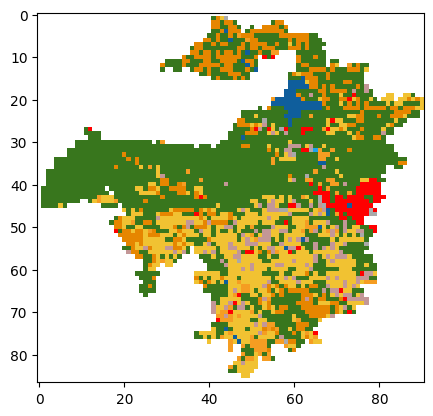

In [ ]:
plt.imshow(img2,interpolation='none', cmap=cmap, norm=norm) #https://stackoverflow.com/questions/32766062/how-to-determine-the-colours-when-using-matplotlib-pyplot-imshow

In [1]:
import PIL

In [3]:
size = (128,128)

In [ ]:
image = Image.fromarray(img2)
image.thumbnail(size)
image.save(thumbnail_path)

In [ ]:
def displayMap(roi_boundary, image):
    centroid = roi_boundary.geometry().centroid()
    coordinates = centroid.coordinates()
    centerLat = coordinates.get(1).getInfo()
    centerLon = coordinates.get(0).getInfo()
    mapObj = folium.Map(width='100%', height='100%', location=[centerLat, centerLon], zoom_start=50)

    # Sattelite image visual parameters
    vis_params = {
        'min': 0,
        'max': 12,
        'palette': ['#000000',  # 0 Black- background
                '#ff0000',   # 1 Red- builtup
                '#74ccf4', # 2 Light Blue- kharif water
                '#1ca3ec', # 3 Blue- kharif and rabi water
                '#0f5e9c', # 4 Dark Blue- kharif and rabi and zaid water
                '#f1c232', # 5 Yellow- croplands
                '#38761d', # 6 Dark Green- Tree/Forests
                '#A9A9A9', # 7 Gray- barren lands
                '#f1c232', # 8 Yellow- Single Kharif Cropping
                '#f59d22', # 9 Mustard- Single Non-Kharif Cropping
                '#e68600', # 10 Orange- Double Cropping
                '#b3561d', # 11 Brown- Triple Cropping
                '#c39797' # 12 Mauve- Shrubs_Scrubs
                ]
        }

    map_id_dict = ee.Image(image).getMapId(vis_params)

    folium.TileLayer(
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Esri',
            name='Esri Satellite',
            overlay=True,
            control=True
        ).add_to(mapObj)

    folium.raster_layers.TileLayer(
                    tiles = map_id_dict['tile_fetcher'].url_format,
                    attr = 'Google Earth Engine',
                    name = 'Sentinel 2 image',
                    overlay = True,
                    control = True
                    ).add_to(mapObj)

    roi_geojson = folium.GeoJson(data=roi_boundary.getInfo(), name='ROI Boundary', style_function=lambda x: {'color':'black', 'fillColor': 'transparent', 'fillOpacity': 0})
    # roi_geojson.add_to(mapObj)

    # Add legend
    legend_html = '''
    <div style="position: fixed; bottom: 200px; right: 100px; z-index:1000; border:2px solid black; background-color:white;
        border-radius:5px; padding:10px; font-size:14px;">
        <p style="font-weight: bold;">Legend</p>
        <p><span style="color: black; font-size: 16px;">■</span> ROI Boundary </p>
        <p><span style="color: #ff0000; font-size: 16px;">■</span> Built-up </p>
        <p><span style="color: #74ccf4; font-size: 16px;">■</span> Water in Kharif </p>
        <p><span style="color: #1ca3ec; font-size: 16px;">■</span> Water in Kharif and Rabi </p>
        <p><span style="color: #0f5e9c; font-size: 16px;">■</span> Water in Kharif, Rabi and Zaid </p>
        <p><span style="color: #38761d; font-size: 16px;">■</span> Tree/Forests </p>
        <p><span style="color: #A9A9A9; font-size: 16px;">■</span> Barren Lands </p>
        <p><span style="color: #f1c232; font-size: 16px;">■</span> Single-Kharif Cropping </p>
        <p><span style="color: #f59d22; font-size: 16px;">■</span> Single Non-Kharif Cropping </p>
        <p><span style="color: #e68600; font-size: 16px;">■</span> Double Cropping </p>
        <p><span style="color: #b3561d; font-size: 16px;">■</span> Triple Cropping </p>
        <p><span style="color: #c39797; font-size: 16px;">■</span> Shrubs and Scrubs </p>
    </div>
    '''
    # mapObj.get_root().html.add_child(folium.Element(legend_html))

    mapObj.add_child(folium.LayerControl())
    display(mapObj)